# Siemens QA Data

In [1]:
from __future__ import division, print_function

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 0.75

import numpy as np
import pandas as pd

from IPython.core.display import display

from lxml import etree

import json

import shlex
from glob import glob
from base64 import b64decode
from os.path import basename, dirname, join
import os

import re

import dateutil
from datetime import datetime

In [2]:
def params_from_xml(group, typedict=None):
    '''Extract 'Parameter' fields from a 'Group'
    '''
    if typedict is None:
        typedict = {}
        
    paramdict = {}
    parameters = group.findall('Parameter')
    for parameter in parameters:
        name = parameter.get('Name')
        value = parameter.text
        if name in typedict:
            value = typedict[name](value)
        paramdict[name] = value
    return paramdict

def general_from_xml(group):
    return params_from_xml(group,{'Columns': int, 'Rows': int})

def roi_from_xml(group):
    return params_from_xml(group,{'Height': int, 'Type': str, 'Width': int, 'X': int, 'Y': int})

def get_coil_name(xmlfile):
    '''
    '''
    root = etree.parse(xmlfile).getroot()
    return dict(token.split(':') for token in shlex.split(root.get('Tags')))['Coil']

def time_stamp(path):
    '''Raw underscore delimited timestamp string encoded in the filename
    '''
    def split_all(path):
        h, t = os.path.split(path)
        return split_all(h) + [t] if h else [t]

    x = re.compile('20......_......_......Z')
    return filter(x.match, split_all(path))[0]


In [3]:
def image_and_roi(filename):
    '''
    '''
    root = etree.parse(filename).getroot()
    groups  = root.findall('Group')
    imagedata = root.find('Data')
    for group in groups:
        if group.get('Name') == 'General':
            general_params = general_from_xml(group)
        elif group.get('Name') == 'ROI':
            roi_params = roi_from_xml(group)   
    nx, ny = general_params['Columns'], general_params['Rows']
    image = np.frombuffer(b64decode(imagedata.text), dtype=np.uint16).reshape((ny, nx)) & 0x0fff
    return image, roi_params

def plot_xml_image_files(filenames):
    '''
    '''
    images_and_rois = [image_and_roi(filename) for filename in filenames]
    nimages = len(images_and_rois)
    ncols = 7
    nrows = int(np.ceil(float(nimages)/ncols))
    fig, axess = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))
    for i, (image, roi) in enumerate(images_and_rois):
        ax = axess.ravel()[i]
        ax.imshow(image, cmap='gray')
        if roi['Type'] == 'Rectangle':
            x0, y0, dx, dy = [roi[k] for k in ['X', 'Y', 'Width', 'Height']]
            ax.add_patch(plt.Rectangle((x0, y0), dx, dy, fill=False, edgecolor="red"))
        ax.axis('off')
        
    if nimages < nrows*ncols:
        for i in range(nimages, nrows*ncols):
            ax = axess.ravel()[i]
            ax.imshow(np.zeros_like(images_and_rois[0][0]), cmap='gray')
            ax.axis('off')

    fig.subplots_adjust(hspace=0.001, wspace=0.001)
    fig.tight_layout()
    
    return

In [4]:
servicedata = 'MriService20150413'
coilname = 'Head_32'
start_date = datetime(2013, 9, 1)
print('Coil is', coilname)

Coil is Head_32


In [5]:
coil_glob = join(servicedata, 'MrSeso', 'site', 'Reports', 'Workflows', 'QA', '*', 'SfpCoilCheckLocalCoils', '*Z.xml')

coil_files = sorted([
    xmlfile for xmlfile in glob(coil_glob)
    if get_coil_name(xmlfile) == coilname
], key=time_stamp)
coil_dir = dirname(coil_files[-1])

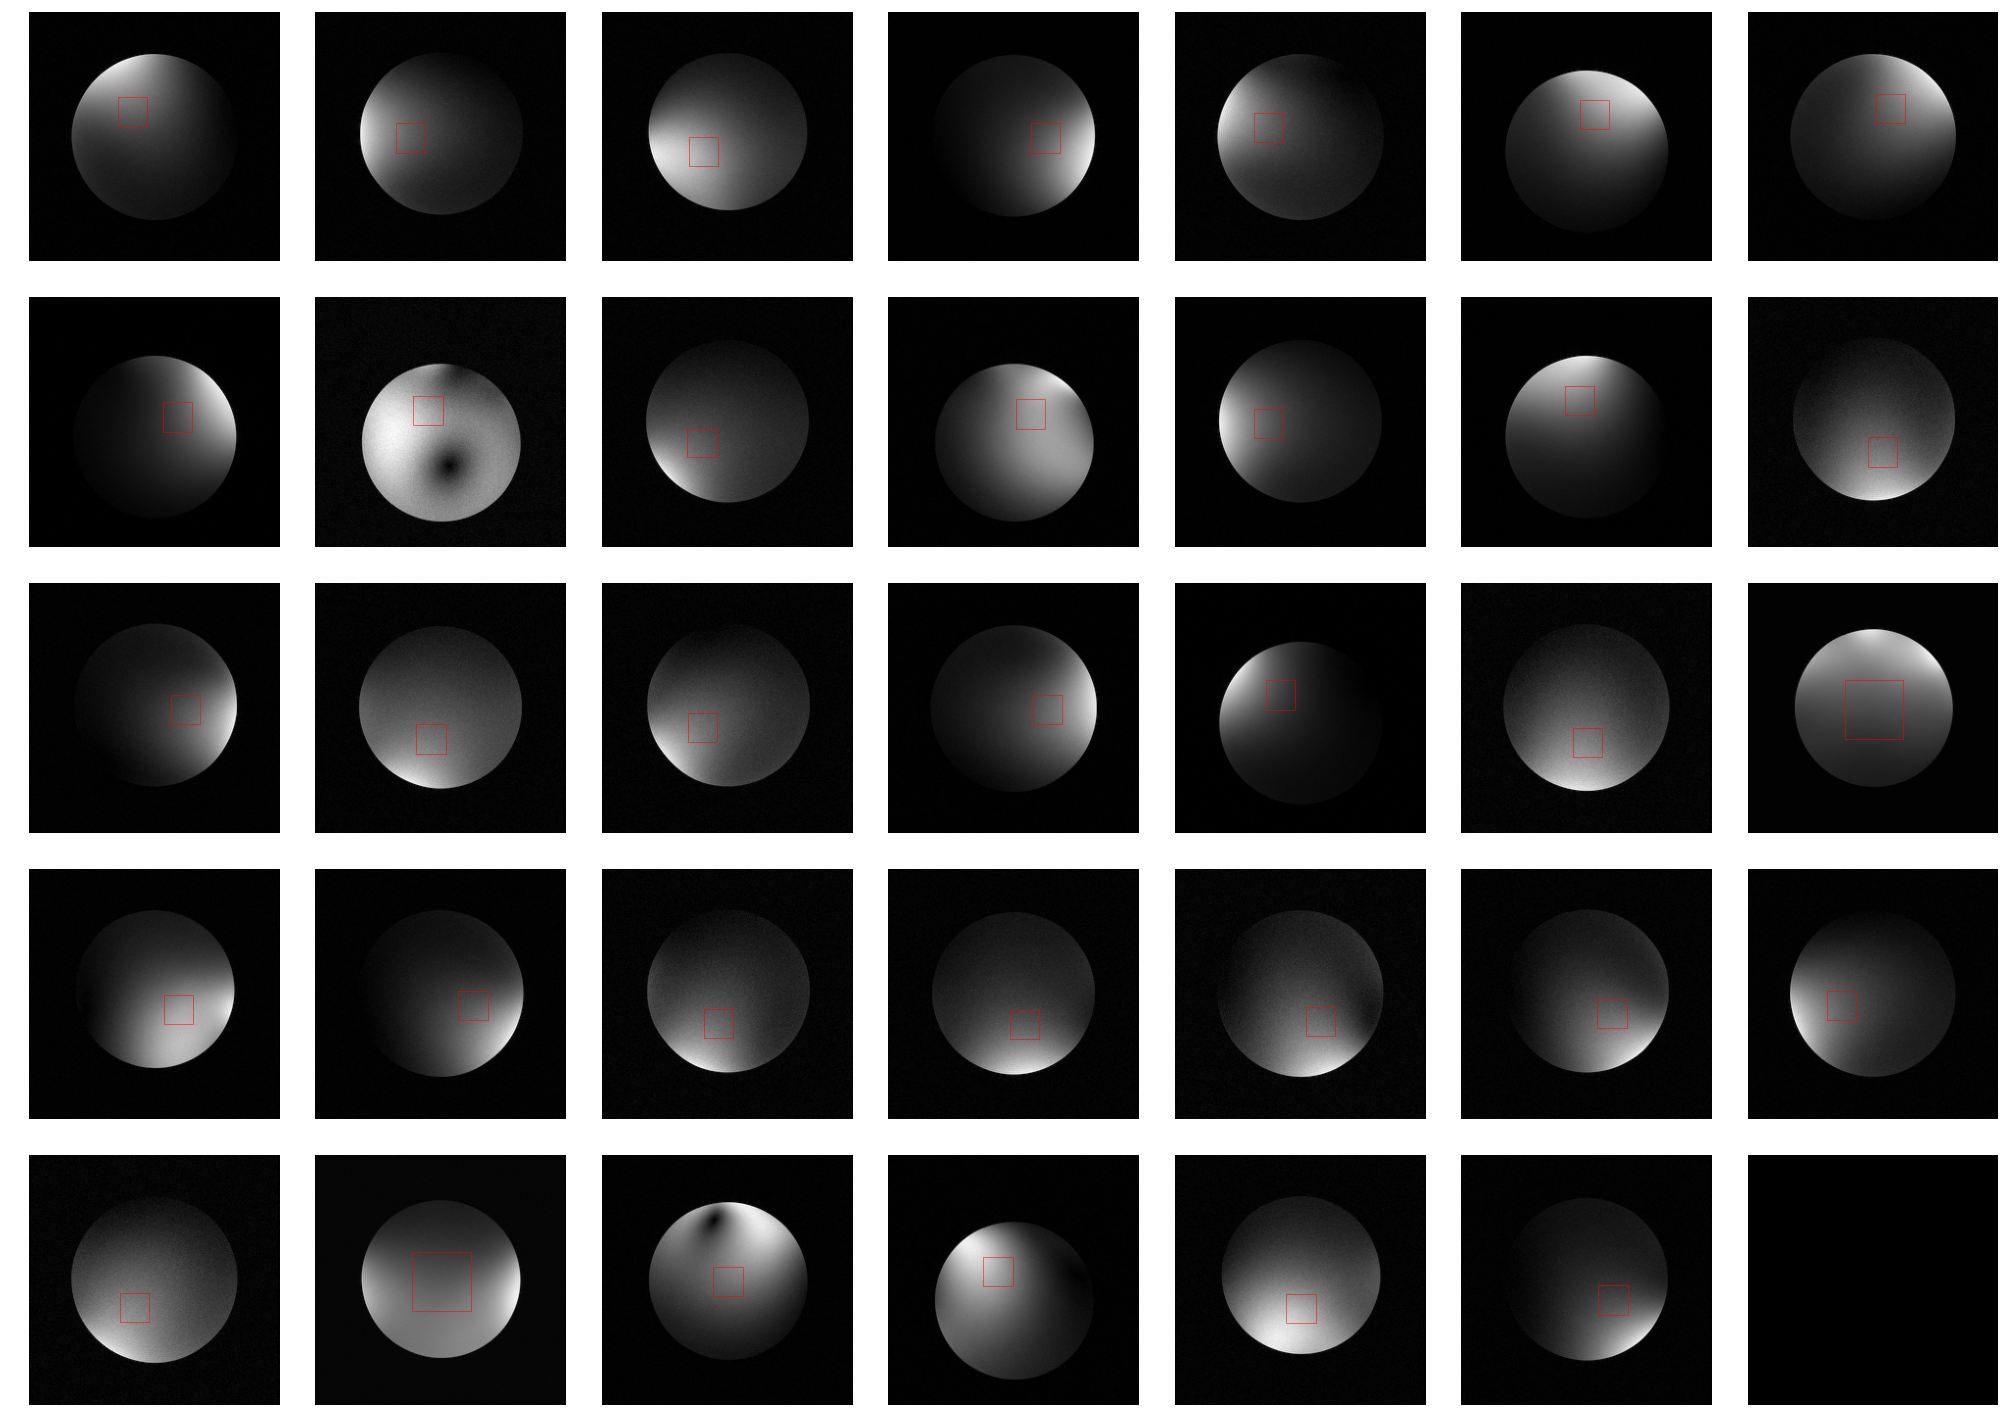

In [6]:
filenames = glob(join(coil_dir, '*Binary*.xml'))
images_and_rois = [image_and_roi(filename) for filename in filenames]
plot_xml_image_files(filenames)

In [8]:
xml_file = coil_files[-1]

root = etree.parse(xml_file).getroot()
snr = snr_table(root)
snr = pd.DataFrame(snr, ['Measured', 'Specification']).T
snr['Margin%'] = ((snr['Measured'] / snr['Specification'] -1) * 100).astype(np.int)
snr['OK?'] = snr['Margin%'] > 20
snr.sort_index()
display(snr)

Measured  \
H1                                                             32.5   
H10                                                            73.3   
H11                                                            29.0   
H12                                                            29.0   
H13                                                            33.1   
H14                                                            30.0   
H15                                                            62.4   
H16                                                            65.9   
H17                                                           108.2   
H18                                                            63.0   
H19                                                            59.4   
H1H2H3H7H8H9H16H17H18H19H25H26                                 91.8   
H2                                                             60.4   
H20                                                            38.0   
H21                                                            24.2   
H22                                                            31.2   
H23                                                            29.0   
H24                                                            40.5   
H25                                                            41.5   
H26                                                            57.1   
H27                                                            43.1   
H28                                                            31.6   
H29                                                            29.2   
H3                                                             90.0   
H30                                                            26.3   
H31                                                            32.0   
H32                                                            42.4   
H4                                                             73.7   
H4H5H6H10H11H12H13H14H15H20H21H22H23H24H27H28H29H30H31H32      63.4   
H5                                                             52.4   
H6                                                             67.9   
H7                                                             89.3   
H8                                                             98.8   
H9                                                             84.1   

                                                           Specification  \
H1                                                                    27   
H10                                                                   48   
H11                                                                   18   
H12                                                                   20   
H13                                                                   26   
H14                                                                   20   
H15                                                                   46   
H16                                                                   44   
H17                                                                   65   
H18                                                                   41   
H19                                                                   35   
H1H2H3H7H8H9H16H17H18H19H25H26                                        63   
H2                                                                    36   
H20                                                                   28   
H21                                                                   17   
H22                                                                   21   
H23                                                                   22   
H24                                                                   24   
H25                                                                   29   
H26                                                  

OK, that seems to be the SNR. There's lots of other stuff there.